## Using Monte Carlo Control

### Part 1: Implementation of Easy21

State s is the tuple (top, sum), action a is 0 for hit and 1 for stick. 

In [1]:
import random, numpy as np

In [2]:
def draw_card():
    value = random.randint(1, 10)
    colour_value = random.random()
    if colour_value < 0.33:
        return -value
    else:
        return value

In [3]:
def step(s, a): # s is the state (top card of dealer, total sum of cards of player) of the game, a is the action (hit or stick), shoud sample a next state s' and reward r.
    if a == 0: # hit
        if s[1] < 21:
            card_value = draw_card() # should return appropriate value of card with correct sign (black -> add, red -> subtract)
            s_new = (s[0], s[1] + card_value)
            if s_new[1] > 21 or s_new[1]< 1 : # player busts
                return s_new, -1
            else:
                return s_new, 0
        else:
            return s, -1
    else: # stick
        dealer_card = draw_card()
        while dealer_card < 17: # dealer hits until the sum is at least 17
            dealer_card += draw_card()
        if dealer_card > 21: # dealer busts
            return s, 1
        elif dealer_card < s[1]: # player wins
            return s, 1
        elif dealer_card == s[1]: # draw
            return s, 0
        else: # dealer wins
            return s, -1

# What is the exact meaning of the "top card of the dealer"?, we are not updating that anywhere in the game, so not sure why it is needed.


### Part 2: Monte Carlo Control Implementation

In [4]:
N = np.zeros((11, 22, 2)) # x -> top card, y -> sum of player, z -> action
number_of_episodes = 1000000

V = np.zeros((11, 22, 2, number_of_episodes + 1))
N0 = 100

for episode in range(number_of_episodes):
    player_value = random.randint(1, 10)
    dealer_value = random.randint(1, 10)
    s = (dealer_value, player_value)
    a = 0 if random.random() < 0.5 else 1 # choose first action randomly

    episode_trajectory = []

    while True:
        s_new, r = step(s, a)
        episode_trajectory.append((s, a, r))

        if r != 0:
            break

        s = s_new
        epsilon_t = N0 / (N0 + N[s[0], s[1], a])
        a = np.argmax(V[s[0], s[1], :, episode]) if random.random() > epsilon_t else random.randint(0, 1)

    G = 0

    for t in reversed(range(len(episode_trajectory))):
        s_t, a_t, r_t = episode_trajectory[t]
        G += r_t

        first_visit = True
        for j in range(t):
            prev_state, prev_action, _ = episode_trajectory[j]
            if prev_state == s_t and prev_action == a_t:
                first_visit = False
                break

        if first_visit and s_t[1] >= 1 and s_t[1] <= 21:
            N[s_t[0], s_t[1], a_t] += 1
            alpha = 1 / N[s_t[0], s_t[1], a_t]
            V[s_t[0], s_t[1], a_t, episode + 1] = V[s_t[0], s_t[1], a_t, episode] + alpha * (G - V[s_t[0], s_t[1], a_t, episode])

    V[:, :, :, episode + 1] = np.where(V[:, :, :, episode + 1] == 0, V[:, :, :, episode], V[:, :, :, episode + 1])

In [5]:
print("Value function for Easy21:"
      "\nHit Action:\n", V[:, :, 0],
      "\nStick Action:\n", V[:, :, 1])

Value function for Easy21:
Hit Action:
 [[[ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  ...
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]]

 [[ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ... -0.606803   -0.606803
   -0.606803  ]
  [ 0.          0.          0.         ... -0.57785743 -0.57785743
   -0.57785743]
  ...
  [ 0.          0.          0.         ... -0.62525458 -0.62525458
   -0.62525458]
  [ 0.          0.          0.         ... -0.65470852 -0.65470852
   -0.65470852]
  [ 0.          0.          0.         ... -1.         -1.
   -1.        ]]

 [[ 0.        

In [6]:
Z_0 = np.transpose(V[:, :, 0])
Z_1 = np.transpose(V[:, :, 1])
Z = np.maximum(Z_0, Z_1)
Z_diff = Z_1 - Z_0
optimal_policy = np.argmax(V, axis=2)

In [7]:
print("\nOptimal Value Function:\n", Z)
print("\nOptimal Policy (0: Hit, 1: Stick):\n", optimal_policy)


Optimal Value Function:
 [[[ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  ...
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]]

 [[ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  ...
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]]

 [[ 0.          0.          0.         ...  0.          0.

### Part 3: Plotting the value function and optiimal policy

In [8]:
import matplotlib.pyplot as plt

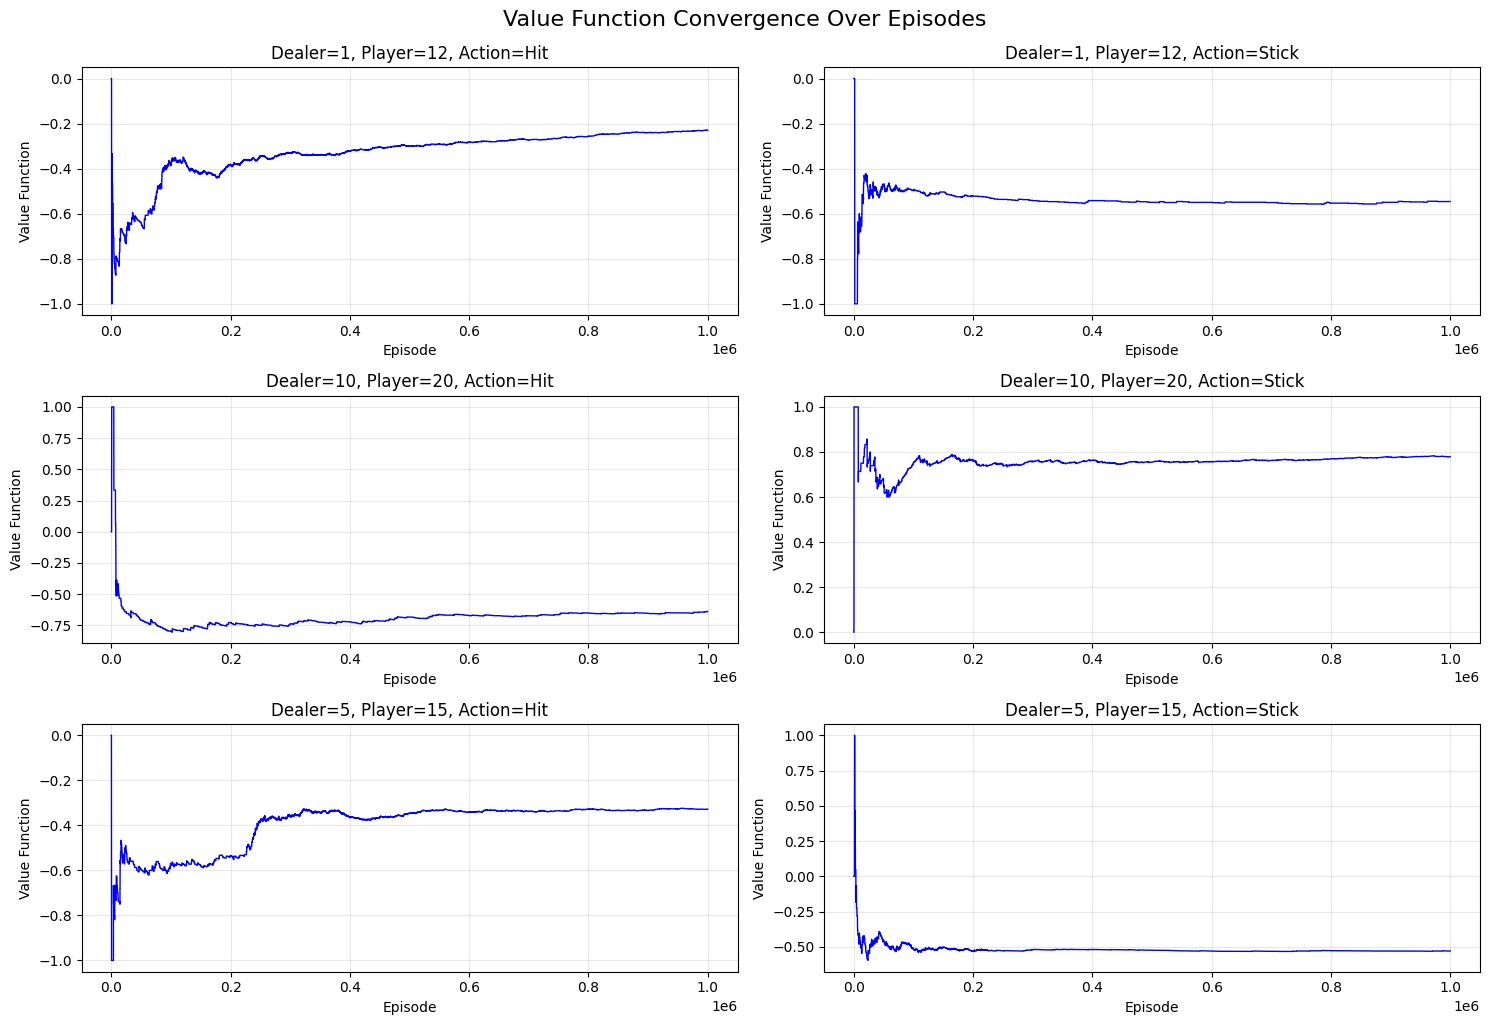

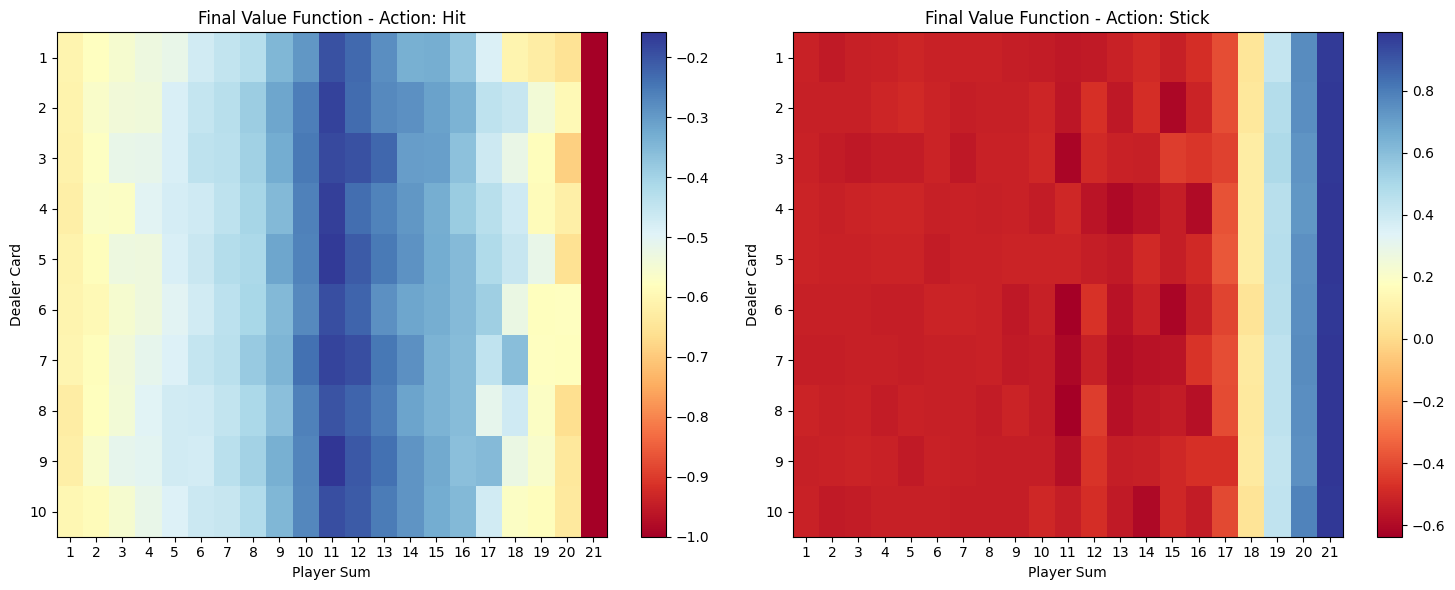

Training completed!
Final V shape: (11, 22, 2, 1000001)
Memory usage: ~3.61 GB


In [11]:
states_to_track = [
    (1, 12, 0),   # dealer=1, player=12, stick
    (1, 12, 1),   # dealer=1, player=12, hit
    (10, 20, 0),  # dealer=10, player=20, stick
    (10, 20, 1),  # dealer=10, player=20, hit
    (5, 15, 0),   # dealer=5, player=15, stick
    (5, 15, 1),   # dealer=5, player=15, hit
]

plt.figure(figsize=(15, 10))

for i, state in enumerate(states_to_track):
    plt.subplot(3, 2, i+1)
    dealer, player, action = state
    values = V[dealer, player, action, :]
    plt.plot(values, 'b-', linewidth=1)

    action_name = "Hit" if action == 0 else "Stick"
    plt.title(f'Dealer={dealer}, Player={player}, Action={action_name}')
    plt.xlabel('Episode')
    plt.ylabel('Value Function')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Value Function Convergence Over Episodes', y=1.02, fontsize=16)
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

im1 = axes[0].imshow(V[1:, 1:, 0, -1], cmap='RdYlBu', aspect='auto')
axes[0].set_title('Final Value Function - Action: Hit')
axes[0].set_xlabel('Player Sum')
axes[0].set_ylabel('Dealer Card')
axes[0].set_xticks(range(21))
axes[0].set_xticklabels(range(1, 22))
axes[0].set_yticks(range(10))
axes[0].set_yticklabels(range(1, 11))
plt.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(V[1:, 1:, 1, -1], cmap='RdYlBu', aspect='auto')
axes[1].set_title('Final Value Function - Action: Stick')
axes[1].set_xlabel('Player Sum')
axes[1].set_ylabel('Dealer Card')
axes[1].set_xticks(range(21))
axes[1].set_xticklabels(range(1, 22))
axes[1].set_yticks(range(10))
axes[1].set_yticklabels(range(1, 11))
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

print("Training completed!")
print(f"Final V shape: {V.shape}")
print(f"Memory usage: ~{V.nbytes / (1024**3):.2f} GB")

ValueError: Argument Z must be 2-dimensional.

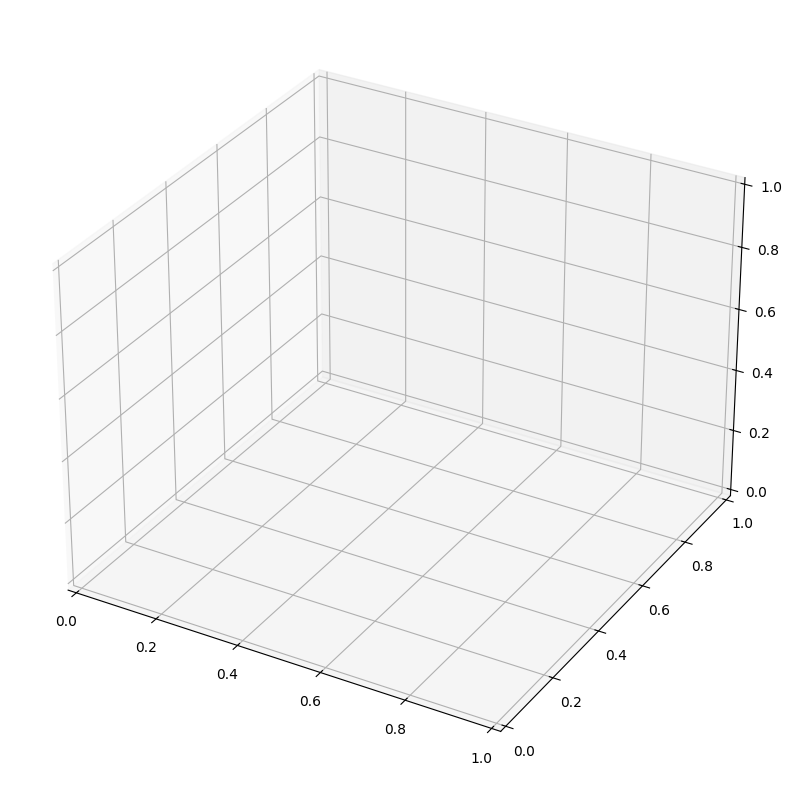

In [10]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(np.arange(0, 11), np.arange(0, 22))
ax.plot_surface(X, Y, Z_0, cmap='viridis')
ax.set_xlabel('Dealer Top Card')
ax.set_ylabel('Player Total Value')
ax.set_zlabel('Value of Hit Action')
ax.set_title('Value Function for Easy21 - Hit Action')
plt.show()

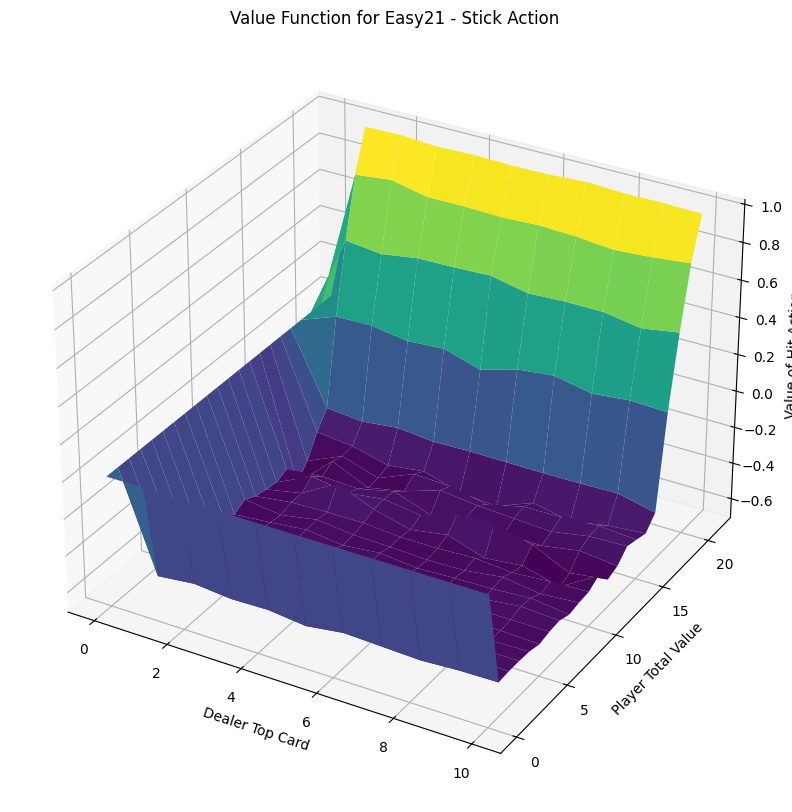

In [ ]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z_1, cmap='viridis')
ax.set_xlabel('Dealer Top Card')
ax.set_ylabel('Player Total Value')
ax.set_zlabel('Value of Hit Action')
ax.set_title('Value Function for Easy21 - Stick Action')
plt.show()

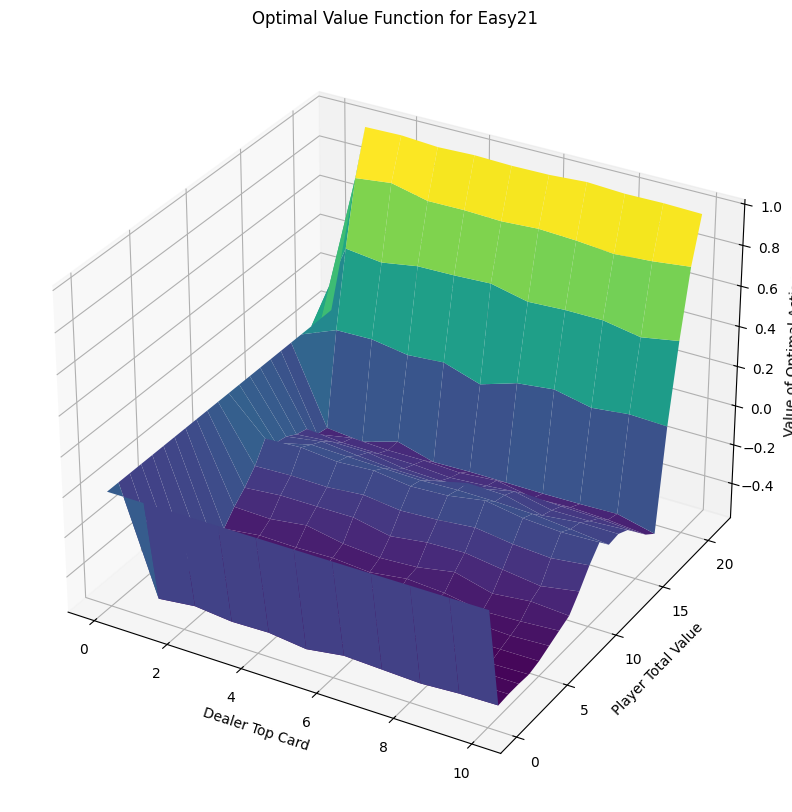

In [ ]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_xlabel('Dealer Top Card')
ax.set_ylabel('Player Total Value')
ax.set_zlabel('Value of Optimal Action')
ax.set_title('Optimal Value Function for Easy21')
plt.show()

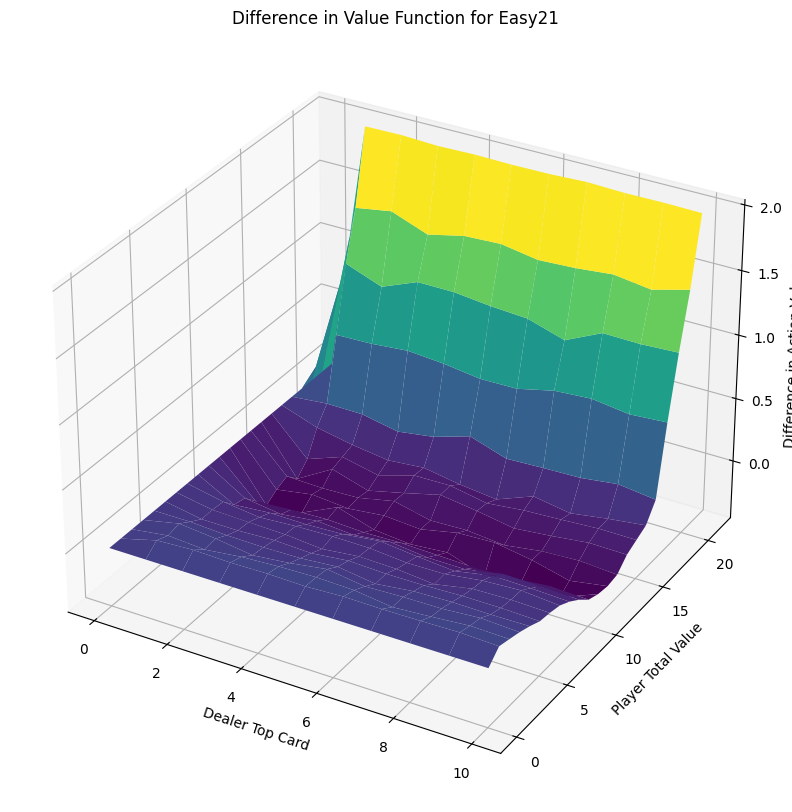

In [ ]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z_diff, cmap='viridis')
ax.set_xlabel('Dealer Top Card')
ax.set_ylabel('Player Total Value')
ax.set_zlabel('Difference in Action Values')
ax.set_title('Difference in Value Function for Easy21')
plt.show()

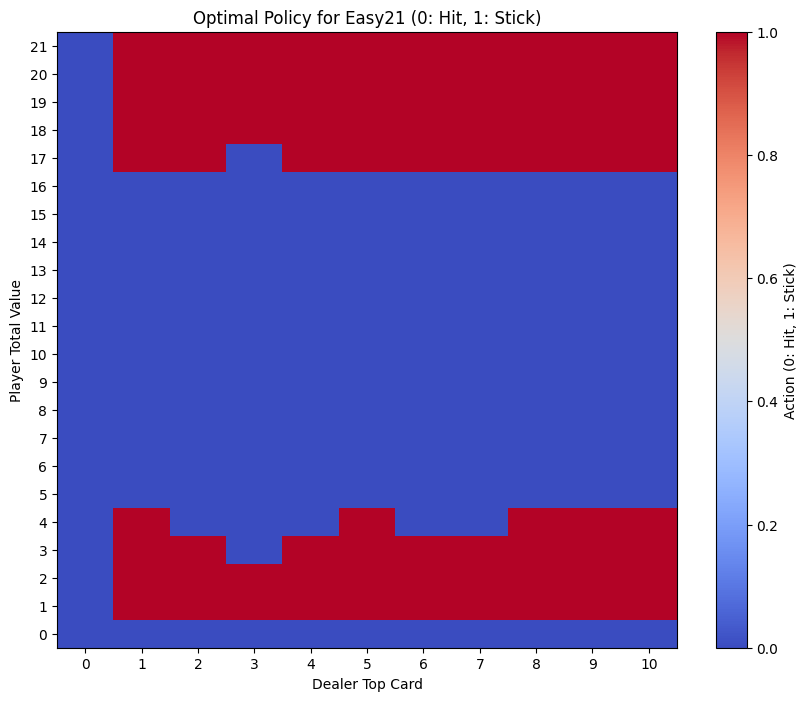

In [ ]:
plt.figure(figsize=(10, 8))
plt.imshow(optimal_policy.T, origin='lower', aspect='auto', cmap='coolwarm')
plt.colorbar(label='Action (0: Hit, 1: Stick)')
plt.xlabel('Dealer Top Card')
plt.ylabel('Player Total Value')
plt.title('Optimal Policy for Easy21 (0: Hit, 1: Stick)')
plt.xticks(ticks=np.arange(optimal_policy.shape[0]), labels=np.arange(optimal_policy.shape[0]))
plt.yticks(ticks=np.arange(optimal_policy.shape[1]), labels=np.arange(optimal_policy.shape[1]))
plt.show()